In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eye-diseases-classification/dataset/glaucoma/1255_right.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/1482_left.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_398_8823411.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_309_4110303.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_13_697490.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_205_310538.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/Glaucoma_040.png
/kaggle/input/eye-diseases-classification/dataset/glaucoma/1256_right.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_221_3079640.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_392_9636183.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_12_5295071.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_399_7128170.jpg
/kaggle/input/eye-diseases-classification/dataset/glaucoma/_113_8738972.jpg
/kaggle/input/eye-disea

In [158]:
folddir="/kaggle/input/eye-diseases-classification/dataset"
classes=os.listdir(folddir)
images_paths=[]
label=[]
for i in classes:
    folderclasspath=os.path.join(folddir,i)
    imagespaths=os.listdir(folderclasspath)
    for j in imagespaths:
        image_path=os.path.join(folderclasspath,j)
        images_paths.append(image_path)
        label.append(i)
df=pd.DataFrame(data={"Image Path":images_paths,"Label":label})
df

,Image Path,Label
0,/kaggle/input/eye-diseases-classification/data...,glaucoma
1,/kaggle/input/eye-diseases-classification/data...,glaucoma
2,/kaggle/input/eye-diseases-classification/data...,glaucoma
3,/kaggle/input/eye-diseases-classification/data...,glaucoma
4,/kaggle/input/eye-diseases-classification/data...,glaucoma
...,...,...
4212,/kaggle/input/eye-diseases-classification/data...,cataract
4213,/kaggle/input/eye-diseases-classification/data...,cataract
4214,/kaggle/input/eye-diseases-classification/data...,cataract
4215,/kaggle/input/eye-diseases-classification/data...,cataract


# Import Libraries

In [16]:
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Dropout,GlobalAveragePooling2D 
from tensorflow.keras.optimizers  import SGD,Adamax,RMSprop,Adam 
from sklearn.metrics import classification_report,confusion_matrix  

In [5]:
df.Label.value_counts()

Label
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

# Show Samples of Data

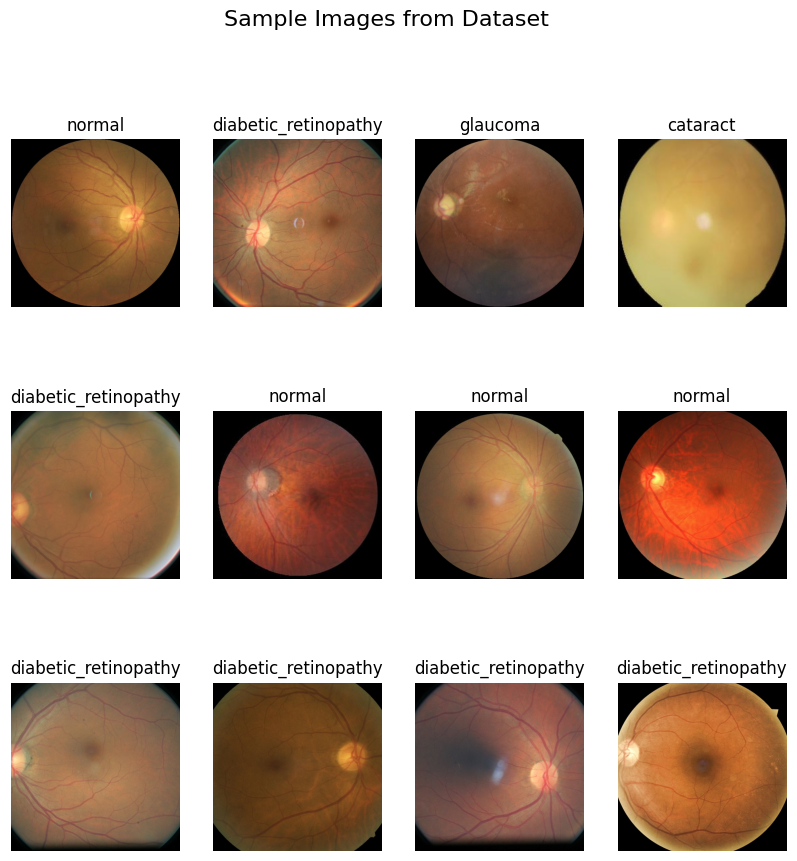

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(10,10))

for i, idx in enumerate(random.sample(range(len(df)), 12)):
    img = mpimg.imread(df.loc[idx, "Image Path"])
    label = df.loc[idx, "Label"]
    
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.show()


# Split Data to Train ,Valid & Test split

* 80% ==> training
* 10% ==> validation
* 10% ==> testing


In [6]:
from sklearn.model_selection import train_test_split

# Step 1: Split into 80% train and 20% temp (validation + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Label"]
)

# Step 2: Split temp (20%) into validation (10%) and test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,           # 50% of 20% = 10%
    random_state=42,
    stratify=temp_df["Label"]
)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")


Train: 3373, Validation: 422, Test: 422


In [7]:
train_df.Label.value_counts()

Label
diabetic_retinopathy    878
normal                  859
cataract                830
glaucoma                806
Name: count, dtype: int64

In [8]:
test_df.Label.value_counts()

Label
diabetic_retinopathy    110
normal                  107
cataract                104
glaucoma                101
Name: count, dtype: int64

# Data Preprocessing

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,              # normalize
    rotation_range=20,            # RandomRotation(0.2)
    horizontal_flip=True,         # RandomFlip
    vertical_flip=True            # RandomFlip
)

val_test_datagen = ImageDataGenerator(
    rescale=1.0/255               # only normalization
)


In [14]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="Image Path",
    y_col="Label",
    target_size=(256,256),   # Resizing
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="Image Path",
    y_col="Label",
    target_size=(256,256),
    batch_size=32,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="Image Path",
    y_col="Label",
    target_size=(256,256),
    batch_size=32,
    class_mode="categorical",
    shuffle=False                 # important for evaluation
)


Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


# Build CNN Model

In [18]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])


In [21]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

In [22]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  
)

Epoch 1/50


I0000 00:00:1765530145.734614     201 service.cc:148] XLA service 0x794910011d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765530145.735501     201 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765530145.735522     201 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765530146.199065     201 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/106 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.2812 - loss: 1.3855 

I0000 00:00:1765530152.133801     201 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 103s 889ms/step - accuracy: 0.3319 - loss: 1.3683 - val_accuracy: 0.4882 - val_loss: 1.2160
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 63s 590ms/step - accuracy: 0.4952 - loss: 1.1572 - val_accuracy: 0.5948 - val_loss: 0.9304
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 64s 598ms/step - accuracy: 0.5770 - loss: 0.9492 - val_accuracy: 0.6445 - val_loss: 0.7964
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 63s 590ms/step - accuracy: 0.6449 - loss: 0.8353 - val_accuracy: 0.6919 - val_loss: 0.7165
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 576ms/step - accuracy: 0.6828 - loss: 0.7467 - val_accuracy: 0.7180 - val_loss: 0.6890
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 574ms/step - accuracy: 0.7110 - loss: 0.6999 - val_accuracy: 0.7299 - val_loss: 0.6941
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 578ms/step - accuracy: 0.7201 - loss: 0.6919 - val_accuracy: 0.7133 - val_loss: 0.6249
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 575ms/step - accuracy: 0.7311 - loss: 0.6497 - va

# Model Evaluation

In [26]:

train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 56s 530ms/step - accuracy: 0.8739 - loss: 0.3119
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.7962 - loss: 0.5338
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 385ms/step - accuracy: 0.8451 - loss: 0.4210
Train Accuracy: 0.8752, Train Loss: 0.3187
Validation Accuracy: 0.8223, Validation Loss: 0.4476
Test Accuracy: 0.8294, Test Loss: 0.4277


# Model Predection

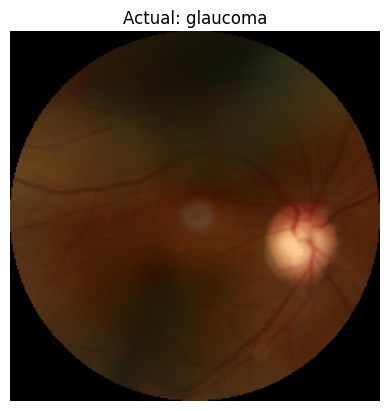

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted label: glaucoma


In [47]:

# Get class names
class_names = list(train_generator.class_indices.keys())

# Take 1 batch from test generator
images_batch, labels_batch = next(iter(test_generator))

# Pick the first image in the batch
first_image = images_batch[0]
first_label = np.argmax(labels_batch[0])

plt.imshow(first_image)
plt.axis("off")
plt.title(f"Actual: {class_names[first_label]}")
plt.show()

# Predict
prediction = model.predict(np.expand_dims(first_image, axis=0))
predicted_label = np.argmax(prediction)

print("Predicted label:", class_names[predicted_label])


# Confusion matrix and Classification report

In [31]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step


Confusion Matrix:
[[ 77   0   8  19]
 [  0 107   0   3]
 [  8   0  69  24]
 [  1   1   8  97]]


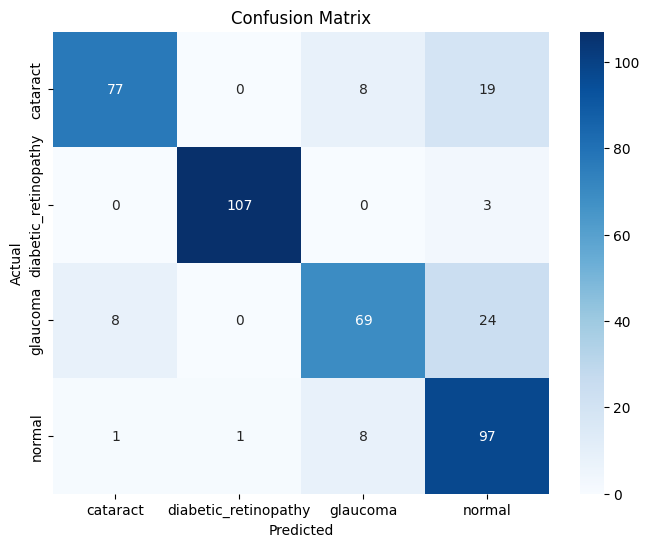

In [40]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [33]:
class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.90      0.74      0.81       104
diabetic_retinopathy       0.99      0.97      0.98       110
            glaucoma       0.81      0.68      0.74       101
              normal       0.68      0.91      0.78       107

            accuracy                           0.83       422
           macro avg       0.84      0.83      0.83       422
        weighted avg       0.85      0.83      0.83       422



# Save the model

In [43]:
model.save("eye_disease_model.h5")

# Transfere Learning
## EfficientNetB0 

In [129]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
from tensorflow.keras.models import Model

In [143]:
from sklearn.model_selection import train_test_split

# Step 1: Split into 80% train and 20% temp (validation + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Label"]
)

# Step 2: Split temp (20%) into validation (10%) and test (10%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,           # 50% of 20% = 10%
    random_state=42,
    stratify=temp_df["Label"]
)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 3373, Validation: 422, Test: 422


In [160]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# ---------------------------
# 3️⃣ Generators
# ---------------------------
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Image Path',
    y_col='Label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


In [161]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base.trainable = True

for layer in base.layers[:-30]:
    layer.trainable = False


x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model2 = Model(inputs=base.input, outputs=output)

model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)



In [162]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
]

In [163]:
history = model2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks,
    verbose=1,
    
)


Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 95s 673ms/step - accuracy: 0.5246 - loss: 1.0944 - val_accuracy: 0.7062 - val_loss: 0.6979 - learning_rate: 1.0000e-04
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 53s 496ms/step - accuracy: 0.7864 - loss: 0.5670 - val_accuracy: 0.7749 - val_loss: 0.5993 - learning_rate: 1.0000e-04
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 52s 493ms/step - accuracy: 0.8364 - loss: 0.4675 - val_accuracy: 0.8081 - val_loss: 0.5351 - learning_rate: 1.0000e-04
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 53s 495ms/step - accuracy: 0.8654 - loss: 0.3791 - val_accuracy: 0.8365 - val_loss: 0.4553 - learning_rate: 1.0000e-04
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 52s 492ms/step - accuracy: 0.8754 - loss: 0.3396 - val_accuracy: 0.8507 - val_loss: 0.4117 - learning_rate: 1.0000e-04
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 53s 497ms/step - accuracy: 0.8794 - loss: 0.3225 - val_accuracy: 0.8531 - val_loss: 0.4068 - learning_rate: 1.0000e-04
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 53s 49

##  Evaluation

In [165]:

train_loss, train_acc = model2.evaluate(train_gen)
val_loss, val_acc = model2.evaluate(val_gen)
test_loss, test_acc = model2.evaluate(test_gen)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

106/106 ━━━━━━━━━━━━━━━━━━━━ 53s 504ms/step - accuracy: 0.9604 - loss: 0.1029
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.8918 - loss: 0.2993
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - accuracy: 0.8924 - loss: 0.2797
Train Accuracy: 0.9662, Train Loss: 0.0990
Validation Accuracy: 0.8839, Validation Loss: 0.3066
Test Accuracy: 0.9028, Test Loss: 0.2764


# Test Data

In [166]:
y_pred_probs =model2.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes


14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 611ms/step


In [167]:
class_names = list(test_gen.class_indices.keys())

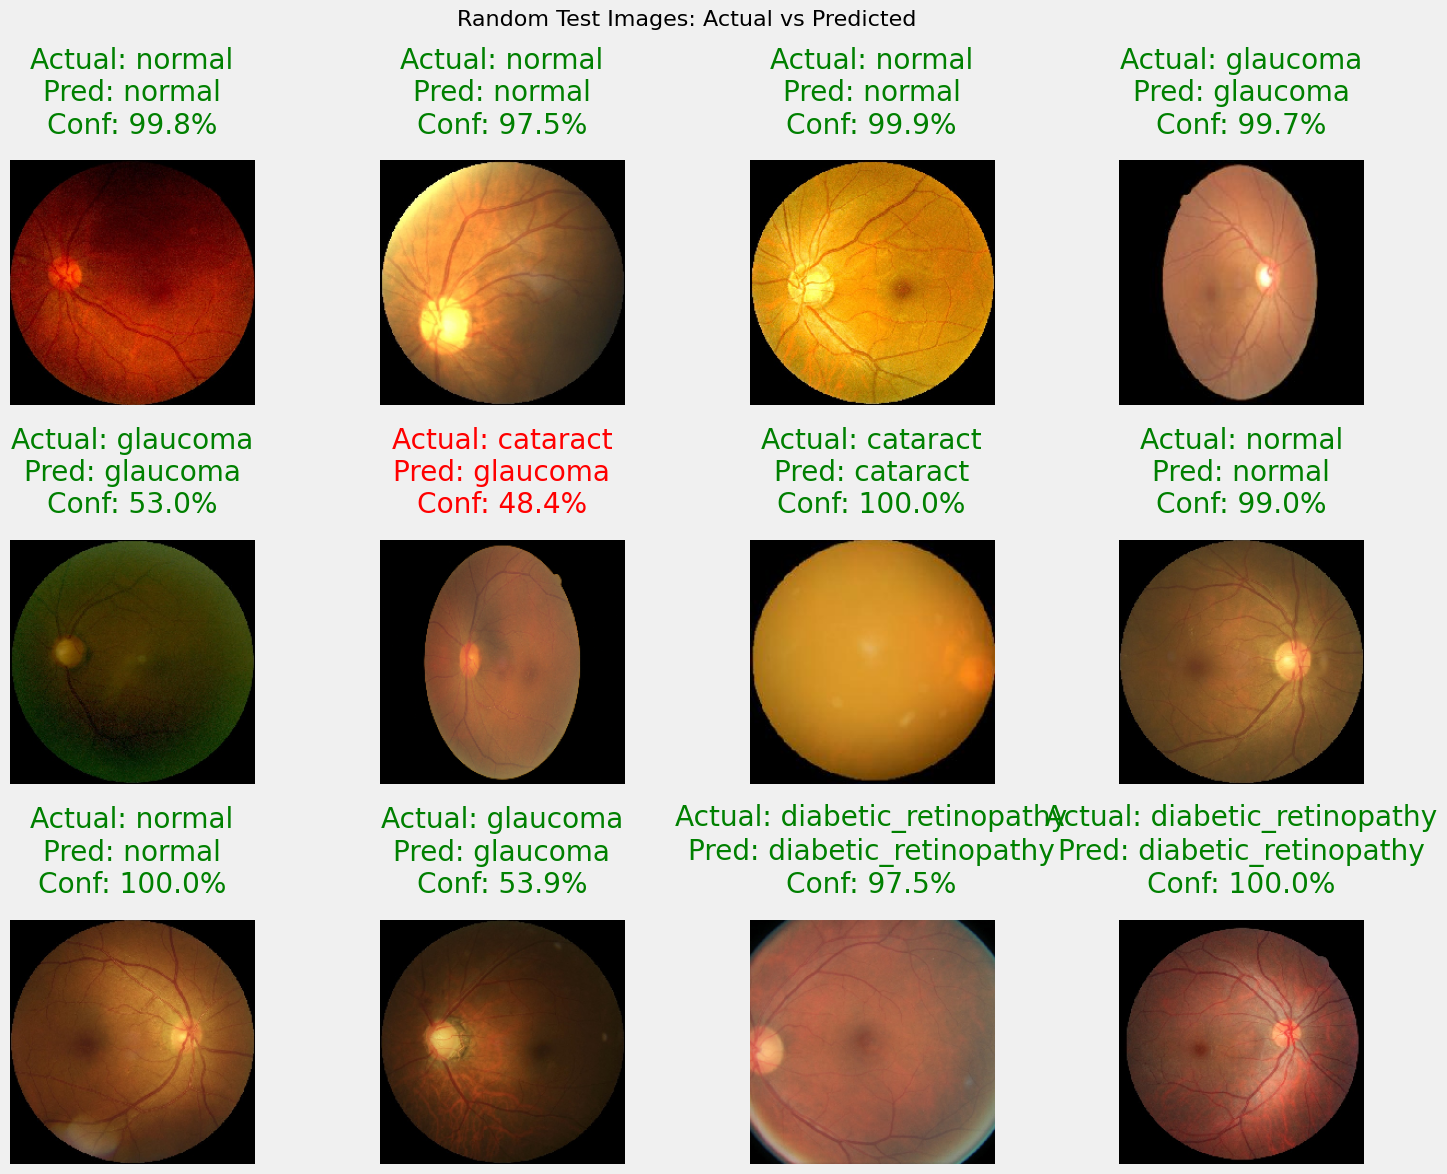

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Get 12 random indices from test dataframe
num_images = 12
indices = np.random.choice(len(test_df), size=num_images, replace=False)

plt.figure(figsize=(15,12))

for i, idx in enumerate(indices):
    # Load image
    img_path = test_df.iloc[idx]['Image Path']
    true_label = test_df.iloc[idx]['Label']
    
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img).astype(np.uint8)  # RGB 0-255

    # Predict using model
    img_input = np.expand_dims(img_array, axis=0)
    img_input = preprocess_input(img_input)  # preprocess for EfficientNet
    pred_probs = model2.predict(img_input, verbose=0)
    pred_idx = np.argmax(pred_probs)
    pred_label = class_names[pred_idx]
    confidence = pred_probs[0][pred_idx] * 100

    # Color title: green if correct, red if wrong
    color = "green" if pred_label == true_label else "red"

    # Plot
    plt.subplot(3, 4, i+1)
    plt.imshow(img_array)  # proper RGB
    plt.axis("off")
    plt.title(f"Actual: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%", color=color,pad=20)

plt.suptitle("Random Test Images: Actual vs Predicted", fontsize=16)
plt.tight_layout()
plt.show()


# Classification Report & confusion matrix

Confusion Matrix:
[[100   0   4   0]
 [  0 104   2   4]
 [  1   1  76  23]
 [  1   2   3 101]]
Classification Report:
                      precision    recall  f1-score   support

            cataract       0.98      0.96      0.97       104
diabetic_retinopathy       0.97      0.95      0.96       110
            glaucoma       0.89      0.75      0.82       101
              normal       0.79      0.94      0.86       107

            accuracy                           0.90       422
           macro avg       0.91      0.90      0.90       422
        weighted avg       0.91      0.90      0.90       422



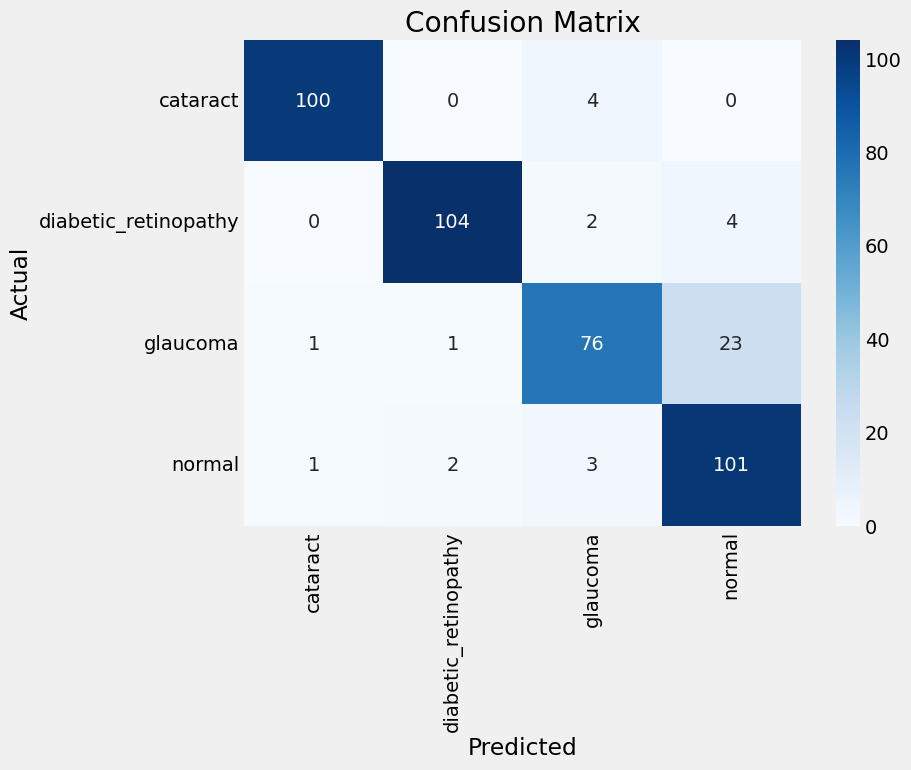

In [176]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
class_names = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)
plt.title("Confusion Matrix")
plt.show()

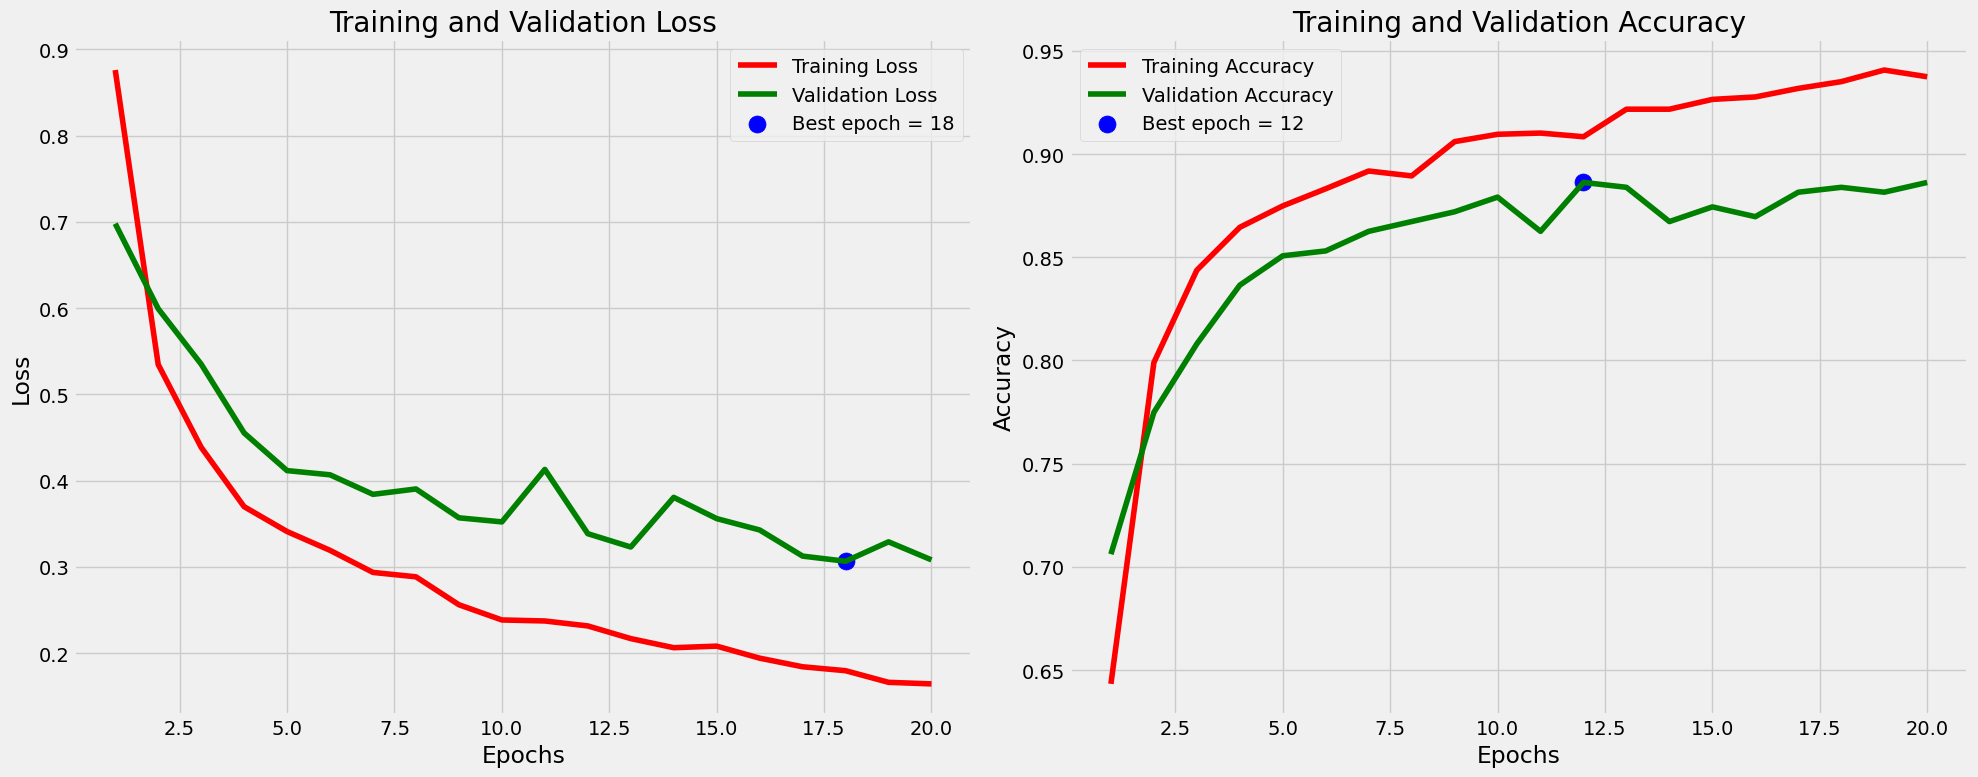

In [177]:
import matplotlib.pyplot as plt
import numpy as np

# Extract training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Find best epochs
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Epoch numbers
Epochs = [i+1 for i in range(len(tr_acc))]

# Labels for scatter points
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Call as function
plt.show()


In [178]:
model2.save("eye_disease_model2.h5")